# **Proyek Analisis Sentimen Ulasan Aplikasi Tokopedia**

- **Nama:** Muhammad Husain Fadhlillah
- **Email Student:** mc006d5y2343@student.devacademy.id
- **Cohort ID:** MC006D5Y2343

## **1. Persiapan Awal**

### 1.1 Instalasi Library Tambahan

In [1]:
# Instalasi library yang mungkin belum ada di lingkungan default
!pip install emoji Sastrawi wordcloud xgboost transformers gensim -q

### 1.2 Import Library

In [2]:
# Untuk mengabaikan peringatan yang tidak relevan agar output lebih bersih
import warnings
warnings.filterwarnings('ignore')

# Import library umum
import pandas as pd
import numpy as np
import re
import string
import emoji
import matplotlib.pyplot as plt
import seaborn as sns

# Import library untuk pra-pemrosesan teks
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Import library untuk ekstraksi fitur
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# Import library untuk pemodelan
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import pipeline

# Import library untuk menyeimbangkan data
from sklearn.utils import resample

# Import library untuk menyimpan model
import joblib

print("Semua library berhasil diimpor.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Semua library berhasil diimpor.


## **2. Pengumpulan dan Pembersihan Data**

### 2.1 Memuat Dataset

In [3]:
# Ganti nama file jika berbeda dengan hasil scraping
nama_file_dataset = "tokopedia_reviews_15000.csv"

# Memuat dataset dari file CSV
try:
    df = pd.read_csv(nama_file_dataset)
    print(f"Dataset '{nama_file_dataset}' berhasil dimuat.")
    print("Info dataset:")
    df.info()
except FileNotFoundError:
    print(f"Error: File '{nama_file_dataset}' tidak ditemukan. Pastikan file berada di direktori yang sama.")

Dataset 'tokopedia_reviews_15000.csv' berhasil dimuat.
Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              15000 non-null  object
 1   userName              15000 non-null  object
 2   userImage             15000 non-null  object
 3   content               15000 non-null  object
 4   score                 15000 non-null  int64 
 5   thumbsUpCount         15000 non-null  int64 
 6   reviewCreatedVersion  11751 non-null  object
 7   at                    15000 non-null  object
 8   replyContent          10260 non-null  object
 9   repliedAt             10260 non-null  object
 10  appVersion            11751 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


### 2.2 Pembersihan Data Awal

In [4]:
# Fokus pada kolom 'content' dan 'score' yang paling relevan
df_clean = df[['content', 'score']].copy()

# Menghapus ulasan yang kosong (NaN)
df_clean.dropna(subset=['content'], inplace=True)

# Menghapus ulasan duplikat
df_clean.drop_duplicates(subset=['content'], inplace=True)

# Menampilkan informasi setelah pembersihan awal
print("Jumlah data setelah menghapus NaN dan duplikat:", len(df_clean))
print("Contoh data:")
df_clean.head()

Jumlah data setelah menghapus NaN dan duplikat: 14976
Contoh data:


,content,score
0,"dulu saya pake Mitra Tokopedia, karena sudah d...",5
1,kok sekarang Tokopedia jadi jelek abis yak? mu...,1
2,"Semenjak Tokopedia di bawah naungan Tiktok, ma...",1
3,"lebih mudah belanja di toko oren (sho...), laz...",1
4,"Kolaborasi & integrasi Tokopedia, Gopay & Bank...",1


### 2.3 Pra-pemrosesan Teks

In [5]:
# Fungsi-fungsi untuk membersihkan teks

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Hapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # Hapus hashtag
    text = re.sub(r'RT[\s]+', '', text) # Hapus RT
    text = re.sub(r'http\S+', '', text) # Hapus link/URL
    text = re.sub(r'[0-9]+', '', text) # Hapus angka
    text = emoji.replace_emoji(text, '') # Hapus emoji
    text = text.translate(str.maketrans('', '', string.punctuation)) # Hapus tanda baca
    text = text.strip() # Hapus spasi di awal dan akhir
    return text

def casefold_text(text):
    return text.lower() # Ubah ke huruf kecil

# Kamus slang words
slang_dict = {
    'yg': 'yang', 'ga': 'tidak', 'gak': 'tidak', 'gk': 'tidak',
    'tdk': 'tidak', 'utk': 'untuk', 'dg': 'dengan', 'bgt': 'banget',
    'jg': 'juga', 'aja': 'saja', 'sm': 'sama', 'tp': 'tapi',
    'klo': 'kalau', 'udh': 'sudah', 'udah': 'sudah', 'sya': 'saya',
    'krn': 'karena', 'dgn': 'dengan', 'skrg': 'sekarang',
    'bnyk': 'banyak', 'mantap': 'bagus', 'keren': 'bagus',
    'jelek': 'buruk', 'parah': 'buruk', 'lemot': 'lambat'
    # Tambahkan slang word lain jika diperlukan
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = [slang_dict[word] if word in slang_dict else word for word in words]
    return ' '.join(fixed_words)

# Menyiapkan stopwords Bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

def filter_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Mengaplikasikan semua fungsi pra-pemrosesan
df_clean['processed_text'] = df_clean['content'].apply(clean_text)
df_clean['processed_text'] = df_clean['processed_text'].apply(casefold_text)
df_clean['processed_text'] = df_clean['processed_text'].apply(fix_slangwords)
df_clean['processed_text'] = df_clean['processed_text'].apply(filter_stopwords)

# Hapus baris yang teksnya menjadi kosong setelah diproses
df_clean.replace('', np.nan, inplace=True)
df_clean.dropna(subset=['processed_text'], inplace=True)


print("Pra-pemrosesan teks selesai.")
print("Jumlah data setelah pra-pemrosesan:", len(df_clean))
df_clean.head()

Pra-pemrosesan teks selesai.
Jumlah data setelah pra-pemrosesan: 14976


,content,score,processed_text
0,"dulu saya pake Mitra Tokopedia, karena sudah d...",5,pake mitra tokopedia dihapus pake tokopedia tr...
1,kok sekarang Tokopedia jadi jelek abis yak? mu...,1,tokopedia buruk abis yak riwayat belanja tampi...
2,"Semenjak Tokopedia di bawah naungan Tiktok, ma...",1,semenjak tokopedia naungan tiktok ampas fitur ...
3,"lebih mudah belanja di toko oren (sho...), laz...",1,mudah belanja toko oren sho laz bli metode pen...
4,"Kolaborasi & integrasi Tokopedia, Gopay & Bank...",1,kolaborasi integrasi tokopedia gopay bank jago...


## **3. Pelabelan dan Penyeimbangan Data**

### 3.1 Pelabelan Data

In [6]:
# Inisialisasi pipeline untuk analisis sentimen dari Hugging Face
# Model ini dilatih khusus untuk sentimen Bahasa Indonesia
sentiment_pipeline = pipeline(model="ridwaanhall/sentimen")

# Fungsi untuk mendapatkan label sentimen
def get_sentiment_label(text):
    try:
        # Kita hanya ambil labelnya saja (positif, negatif, netral)
        return sentiment_pipeline(text)[0]['label']
    except Exception as e:
        return 'netral' # Default ke netral jika ada error

# Melakukan pelabelan pada kolom 'processed_text'
# Proses ini mungkin memakan waktu beberapa menit tergantung jumlah data
df_clean['sentiment'] = df_clean['processed_text'].apply(get_sentiment_label)

print("Pelabelan data selesai.")
df_clean.head()

config.json:   0%|          | 0.00/922 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/736k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Pelabelan data selesai.


,content,score,processed_text,sentiment
0,"dulu saya pake Mitra Tokopedia, karena sudah d...",5,pake mitra tokopedia dihapus pake tokopedia tr...,netral
1,kok sekarang Tokopedia jadi jelek abis yak? mu...,1,tokopedia buruk abis yak riwayat belanja tampi...,negatif
2,"Semenjak Tokopedia di bawah naungan Tiktok, ma...",1,semenjak tokopedia naungan tiktok ampas fitur ...,netral
3,"lebih mudah belanja di toko oren (sho...), laz...",1,mudah belanja toko oren sho laz bli metode pen...,negatif
4,"Kolaborasi & integrasi Tokopedia, Gopay & Bank...",1,kolaborasi integrasi tokopedia gopay bank jago...,positif


### 3.2 Analisis Distribusi Kelas

Distribusi Kelas Sentimen Sebelum Penyeimbangan:
sentiment
negatif    7415
positif    3906
netral     3655
Name: count, dtype: int64


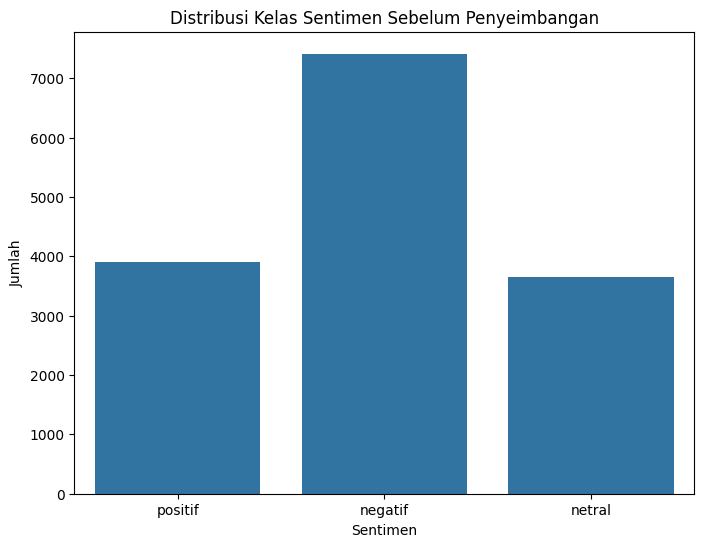

In [7]:
# Menampilkan jumlah data untuk setiap kelas sentimen
print("Distribusi Kelas Sentimen Sebelum Penyeimbangan:")
print(df_clean['sentiment'].value_counts())

# Visualisasi distribusi kelas
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_clean, order=['positif', 'negatif', 'netral'])
plt.title('Distribusi Kelas Sentimen Sebelum Penyeimbangan')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

### 3.3 Penyeimbangan Data dengan Upsampling

In [8]:
# Memisahkan data berdasarkan kelas
df_positif = df_clean[df_clean.sentiment == 'positif']
df_negatif = df_clean[df_clean.sentiment == 'negatif']
df_netral = df_clean[df_clean.sentiment == 'netral']

# Menentukan jumlah sampel mayoritas
max_size = df_clean['sentiment'].value_counts().max()

# Melakukan upsampling pada kelas minoritas
df_positif_upsampled = resample(df_positif, replace=True, n_samples=max_size, random_state=42)
df_negatif_upsampled = resample(df_negatif, replace=True, n_samples=max_size, random_state=42)
df_netral_upsampled = resample(df_netral, replace=True, n_samples=max_size, random_state=42)


# Menggabungkan kembali dataframe yang sudah seimbang
df_balanced = pd.concat([df_positif_upsampled, df_negatif_upsampled, df_netral_upsampled])

print("Penyeimbangan data selesai.")

Penyeimbangan data selesai.


### 3.4 Distribusi Kelas Setelah Penyeimbangan


Distribusi Kelas Sentimen Setelah Penyeimbangan:
sentiment
positif    7415
negatif    7415
netral     7415
Name: count, dtype: int64


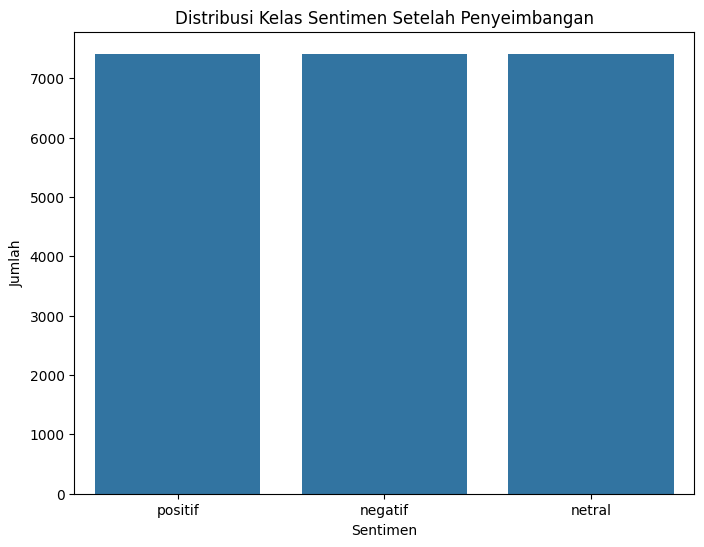

In [9]:
# Menampilkan jumlah data setelah penyeimbangan
print("\nDistribusi Kelas Sentimen Setelah Penyeimbangan:")
print(df_balanced['sentiment'].value_counts())

# Visualisasi distribusi kelas setelah penyeimbangan
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_balanced, order=['positif', 'negatif', 'netral'])
plt.title('Distribusi Kelas Sentimen Setelah Penyeimbangan')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

## **4. Eksperimen dan Pelatihan Model**

### 4.1 Persiapan Data untuk Pelatihan

In [10]:
# Memisahkan fitur (X) dan target (y)
X = df_balanced['processed_text']
y = df_balanced['sentiment']

# Mengubah label target menjadi numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Data siap untuk dilatih.")

Data siap untuk dilatih.


### 4.2 Desain 3 Skema Eksperimen
Berikut adalah 3 skema yang akan diuji untuk memenuhi kriteria Bintang 5:
1.  **Skema 1 (Target > 92%)**: Random Forest + Word2Vec + Split 90/10
2.  **Skema 2 (Target > 85%)**: XGBoost + Word2Vec + Split 80/20
3.  **Skema 3 (Target > 85%)**: Logistic Regression + TF-IDF + Split 80/20

#### --- SKEMA 1: Random Forest + Word2Vec (Target Akurasi > 92%) ---

In [11]:
# Membagi data untuk Skema 1
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y_encoded, test_size=0.1, random_state=42, stratify=y_encoded)

# Ekstraksi Fitur Word2Vec
sent_train1 = [row.split() for row in X_train1]
w2v_model1 = Word2Vec(sent_train1, vector_size=100, window=5, min_count=5, workers=4)

def vectorize(sentence, model):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    return np.mean(words_vecs, axis=0) if len(words_vecs) > 0 else np.zeros(model.vector_size)

X_train1_vec = np.array([vectorize(sentence, w2v_model1) for sentence in X_train1])
X_test1_vec = np.array([vectorize(sentence, w2v_model1) for sentence in X_test1])

# Pelatihan Model Random Forest
rf_model = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
rf_model.fit(X_train1_vec, y_train1)

# Evaluasi Skema 1
y_pred1_train = rf_model.predict(X_train1_vec)
y_pred1_test = rf_model.predict(X_test1_vec)

print("--- Hasil Evaluasi Skema 1 ---")
print(f"Akurasi Training: {accuracy_score(y_train1, y_pred1_train) * 100:.2f}%")
print(f"Akurasi Testing: {accuracy_score(y_test1, y_pred1_test) * 100:.2f}%")
print("\nLaporan Klasifikasi (Data Test):")
print(classification_report(y_test1, y_pred1_test, target_names=label_encoder.classes_))

--- Hasil Evaluasi Skema 1 ---
Akurasi Training: 99.98%
Akurasi Testing: 93.03%

Laporan Klasifikasi (Data Test):
              precision    recall  f1-score   support

     negatif       0.91      0.91      0.91       741
      netral       0.93      0.94      0.93       742
     positif       0.95      0.94      0.95       742

    accuracy                           0.93      2225
   macro avg       0.93      0.93      0.93      2225
weighted avg       0.93      0.93      0.93      2225



#### --- SKEMA 2: XGBoost + Word2Vec (Target Akurasi > 85%) ---

In [12]:
# Membagi data untuk Skema 2
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Ekstraksi Fitur Word2Vec
sent_train2 = [row.split() for row in X_train2]
w2v_model2 = Word2Vec(sent_train2, vector_size=100, window=5, min_count=5, workers=4)
X_train2_vec = np.array([vectorize(sentence, w2v_model2) for sentence in X_train2])
X_test2_vec = np.array([vectorize(sentence, w2v_model2) for sentence in X_test2])

# Pelatihan Model XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train2_vec, y_train2)

# Evaluasi Skema 2
# Calculate training predictions for Skema 2
y_pred2_train = xgb_model.predict(X_train2_vec) # Add this line
y_pred2_test = xgb_model.predict(X_test2_vec)

print("\n--- Hasil Evaluasi Skema 2 ---")
print(f"Akurasi Training: {accuracy_score(y_train2, y_pred2_train) * 100:.2f}%")
print(f"Akurasi Testing: {accuracy_score(y_test2, y_pred2_test) * 100:.2f}%")
print("\nLaporan Klasifikasi (Data Test):")
print(classification_report(y_test2, y_pred2_test, target_names=label_encoder.classes_))


--- Hasil Evaluasi Skema 2 ---
Akurasi Training: 99.72%
Akurasi Testing: 90.31%

Laporan Klasifikasi (Data Test):
              precision    recall  f1-score   support

     negatif       0.88      0.89      0.88      1483
      netral       0.89      0.91      0.90      1483
     positif       0.94      0.92      0.93      1483

    accuracy                           0.90      4449
   macro avg       0.90      0.90      0.90      4449
weighted avg       0.90      0.90      0.90      4449



#### --- SKEMA 3: Logistic Regression + TF-IDF (Target Akurasi > 85%) ---

In [13]:
# Membagi data untuk Skema 3
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Ekstraksi Fitur TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train3_vec = tfidf_vectorizer.fit_transform(X_train3)
X_test3_vec = tfidf_vectorizer.transform(X_test3)

# Pelatihan Model Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train3_vec, y_train3)

# Evaluasi Skema 3
# Calculate training predictions for Skema 3 - ADDED THIS LINE
y_pred3_train = lr_model.predict(X_train3_vec)
y_pred3_test = lr_model.predict(X_test3_vec)

print("\n--- Hasil Evaluasi Skema 3 ---")
print(f"Akurasi Training: {accuracy_score(y_train3, y_pred3_train) * 100:.2f}%")
print(f"Akurasi Testing: {accuracy_score(y_test3, y_pred3_test) * 100:.2f}%")
print("\nLaporan Klasifikasi (Data Test):")
print(classification_report(y_test3, y_pred3_test, target_names=label_encoder.classes_))


--- Hasil Evaluasi Skema 3 ---
Akurasi Training: 94.46%
Akurasi Testing: 89.17%

Laporan Klasifikasi (Data Test):
              precision    recall  f1-score   support

     negatif       0.89      0.88      0.88      1483
      netral       0.86      0.90      0.88      1483
     positif       0.93      0.90      0.91      1483

    accuracy                           0.89      4449
   macro avg       0.89      0.89      0.89      4449
weighted avg       0.89      0.89      0.89      4449



### 4.3 Menyimpan Model Terbaik

In [14]:
# Model terbaik adalah dari Skema 1 (Random Forest)
# Kita simpan model, vectorizer (Word2Vec), dan label encoder

joblib.dump(rf_model, 'model_random_forest.joblib')
w2v_model1.save("model_word2vec.w2v")
joblib.dump(label_encoder, 'label_encoder.joblib')

print("Model terbaik (Random Forest), Word2Vec, dan Label Encoder berhasil disimpan.")

Model terbaik (Random Forest), Word2Vec, dan Label Encoder berhasil disimpan.


## **5. Inference (Pengujian Model pada Data Baru)**

In [15]:
# Membuat class untuk inference agar lebih rapi
class SentimentAnalyzer:
    def __init__(self, model_path, w2v_path, encoder_path):
        # Memuat semua file yang dibutuhkan
        self.model = joblib.load(model_path)
        self.w2v_model = Word2Vec.load(w2v_path)
        self.encoder = joblib.load(encoder_path)

    def _vectorize(self, sentence):
        # Fungsi internal untuk mengubah teks menjadi vektor
        words = sentence.split()
        words_vecs = [self.w2v_model.wv[word] for word in words if word in self.w2v_model.wv]
        return np.mean(words_vecs, axis=0) if len(words_vecs) > 0 else np.zeros(self.w2v_model.vector_size)

    def predict(self, text):
        # 1. Pra-pemrosesan teks input
        processed_text = clean_text(text)
        processed_text = casefold_text(processed_text)
        processed_text = fix_slangwords(processed_text)
        processed_text = filter_stopwords(processed_text)

        # 2. Vektorisasi teks
        vectorized_text = self._vectorize(processed_text).reshape(1, -1)

        # 3. Prediksi menggunakan model
        prediction_code = self.model.predict(vectorized_text)[0]

        # 4. Mengubah kode prediksi kembali menjadi label teks
        prediction_label = self.encoder.inverse_transform([prediction_code])[0]

        return prediction_label

# Inisialisasi analyzer dengan model terbaik yang sudah disimpan
analyzer = SentimentAnalyzer(
    model_path='model_random_forest.joblib',
    w2v_path='model_word2vec.w2v',
    encoder_path='label_encoder.joblib'
)

# Contoh kalimat untuk diuji
kalimat_positif = "Aplikasinya bagus sekali dan sangat membantu!"
kalimat_negatif = "Update terbaru malah bikin error dan lemot parah."
kalimat_netral = "Saya baru saja menginstall aplikasi tokopedia."

# Melakukan prediksi
prediksi1 = analyzer.predict(kalimat_positif)
prediksi2 = analyzer.predict(kalimat_negatif)
prediksi3 = analyzer.predict(kalimat_netral)

# Menampilkan hasil inference
print("--- Hasil Inference ---")
print(f'Teks: "{kalimat_positif}" \n--> Prediksi Sentimen: {prediksi1.upper()}')
print("-" * 20)
print(f'Teks: "{kalimat_negatif}" \n--> Prediksi Sentimen: {prediksi2.upper()}')
print("-" * 20)
print(f'Teks: "{kalimat_netral}" \n--> Prediksi Sentimen: {prediksi3.upper()}')

--- Hasil Inference ---
Teks: "Aplikasinya bagus sekali dan sangat membantu!" 
--> Prediksi Sentimen: POSITIF
--------------------
Teks: "Update terbaru malah bikin error dan lemot parah." 
--> Prediksi Sentimen: NEGATIF
--------------------
Teks: "Saya baru saja menginstall aplikasi tokopedia." 
--> Prediksi Sentimen: NETRAL
